# Figure 8

In [1]:
import pyleoclim as pyleo
import numpy as np
import ammonyte as ammo
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from pangaeapy.pandataset import PanDataSet
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

In [ ]:
#We suppress warnings for these notebooks for presentation purposes. Best practice is to not do this though.
import warnings
warnings.filterwarnings('ignore')

In [2]:
def detect_transitions(series,transition_interval=None):
    '''Function to detect transitions across a confidence interval
    
    Parameters
    ----------
    
    series : pyleo.Series, amt.Series
        Series to detect transitions upon
        
    transition_interval : list,tuple
        Upper and lower bound for the transition interval
    
    Returns
    -------
    
    transitions : list
        Timing of the transitions of the series across its confidence interval
    '''
    series_fine = series.interp(step=1)
    
    if transition_interval is None:
        upper, lower = amt.utils.sampling.confidence_interval(series)
    else:
        upper, lower = transition_interval

    above_thresh = np.where(series_fine.value > upper,1,0)
    below_thresh = np.where(series_fine.value < lower,1,0)

    transition_above = np.diff(above_thresh)
    transition_below = np.diff(below_thresh)

    upper_trans = series_fine.time[1:][np.diff(above_thresh) != 0]
    lower_trans = series_fine.time[1:][np.diff(below_thresh) != 0]

    full_trans = np.zeros(len(transition_above))

    last_above = 0
    last_below = 0
    for i in range(len(transition_above)):
        above = transition_above[i]
        below = transition_below[i]
        if above != 0:
            if last_below+above == 0:
                loc = int((i+below_pointer)/2)
                full_trans[loc] = 1
                last_below=0
            last_above = above
            above_pointer = i
        if below != 0:
            if last_above + below == 0:
                loc = int((i+above_pointer)/2)
                full_trans[loc] = 1
                last_above=0
            last_below = below
            below_pointer = i

    transitions = series_fine.time[1:][full_trans != 0]
    
    return transitions

First we load the U1308 oxygen isotope data from Pangaea

Time axis values sorted in ascending order


/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_2237/3890698746.py:2: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  tsb = pyleo.Series(time=dsb.data['Age'], value=dsb.data['C. wuellerstorfi δ18O'],


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka BP]', ylabel='$\\delta^{18}$O x (-1) [‰]'>)

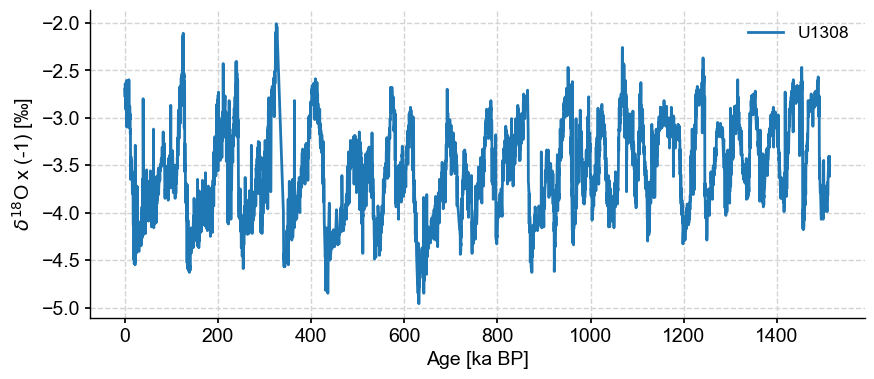

In [3]:
dsb = PanDataSet('10.1594/PANGAEA.831735')
tsb = pyleo.Series(time=dsb.data['Age'], value=dsb.data['C. wuellerstorfi δ18O'],
                      time_name='Age', time_unit='ka BP', label = 'U1308',
                      value_name='$\delta^{18}$O', value_unit=u'‰').flip()
tsb.plot()


We carry out LERM analysis on the record binned to different resolutions (.5, 2.5, and 4.5 kyr)

We use an embedding dimension of 13, a tau determined by the first minimum of mutual information, a recurrence density of roughly 5%, and a window size and window increment of 50 and 5 respectively.

In [4]:
lp_fi = {}
series_lp = {}
bin_sizes = [.5,2.5,4.5] 

for bin_size in bin_sizes:
    series = tsb.interp().bin(bin_size=bin_size).convert_time_unit('Years')
    series_lp[bin_size] = series.convert_time_unit('ka')
    amt_series = ammo.Series(
        time=series.time,
        value=series.value,
        time_name = series.time_name,
        value_name = series.value_name,
        time_unit = series.time_unit,
        value_unit = series.value_unit,
        label = series.label,
        clean_ts=False,
        sort_ts=None,
    )
    td = amt_series.embed(13)
    print(f'Bin size {bin_size} tau is: {td.tau}')
    eps = td.find_epsilon(eps=1,target_density=.05,tolerance=.01,verbose=False)
    rm = eps['Output']
    lp_series = rm.laplacian_eigenmaps(w_size=50,w_incre=5)
    lp_series = lp_series.convert_time_unit('ka')
    lp_fi[bin_size] = lp_series

/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_2237/2503865442.py:8: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = ammo.Series(


Bin size 0.5 tau is: 12


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_2237/2503865442.py:8: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = ammo.Series(


Bin size 2.5 tau is: 5


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_2237/2503865442.py:8: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = ammo.Series(


Bin size 4.5 tau is: 6


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)


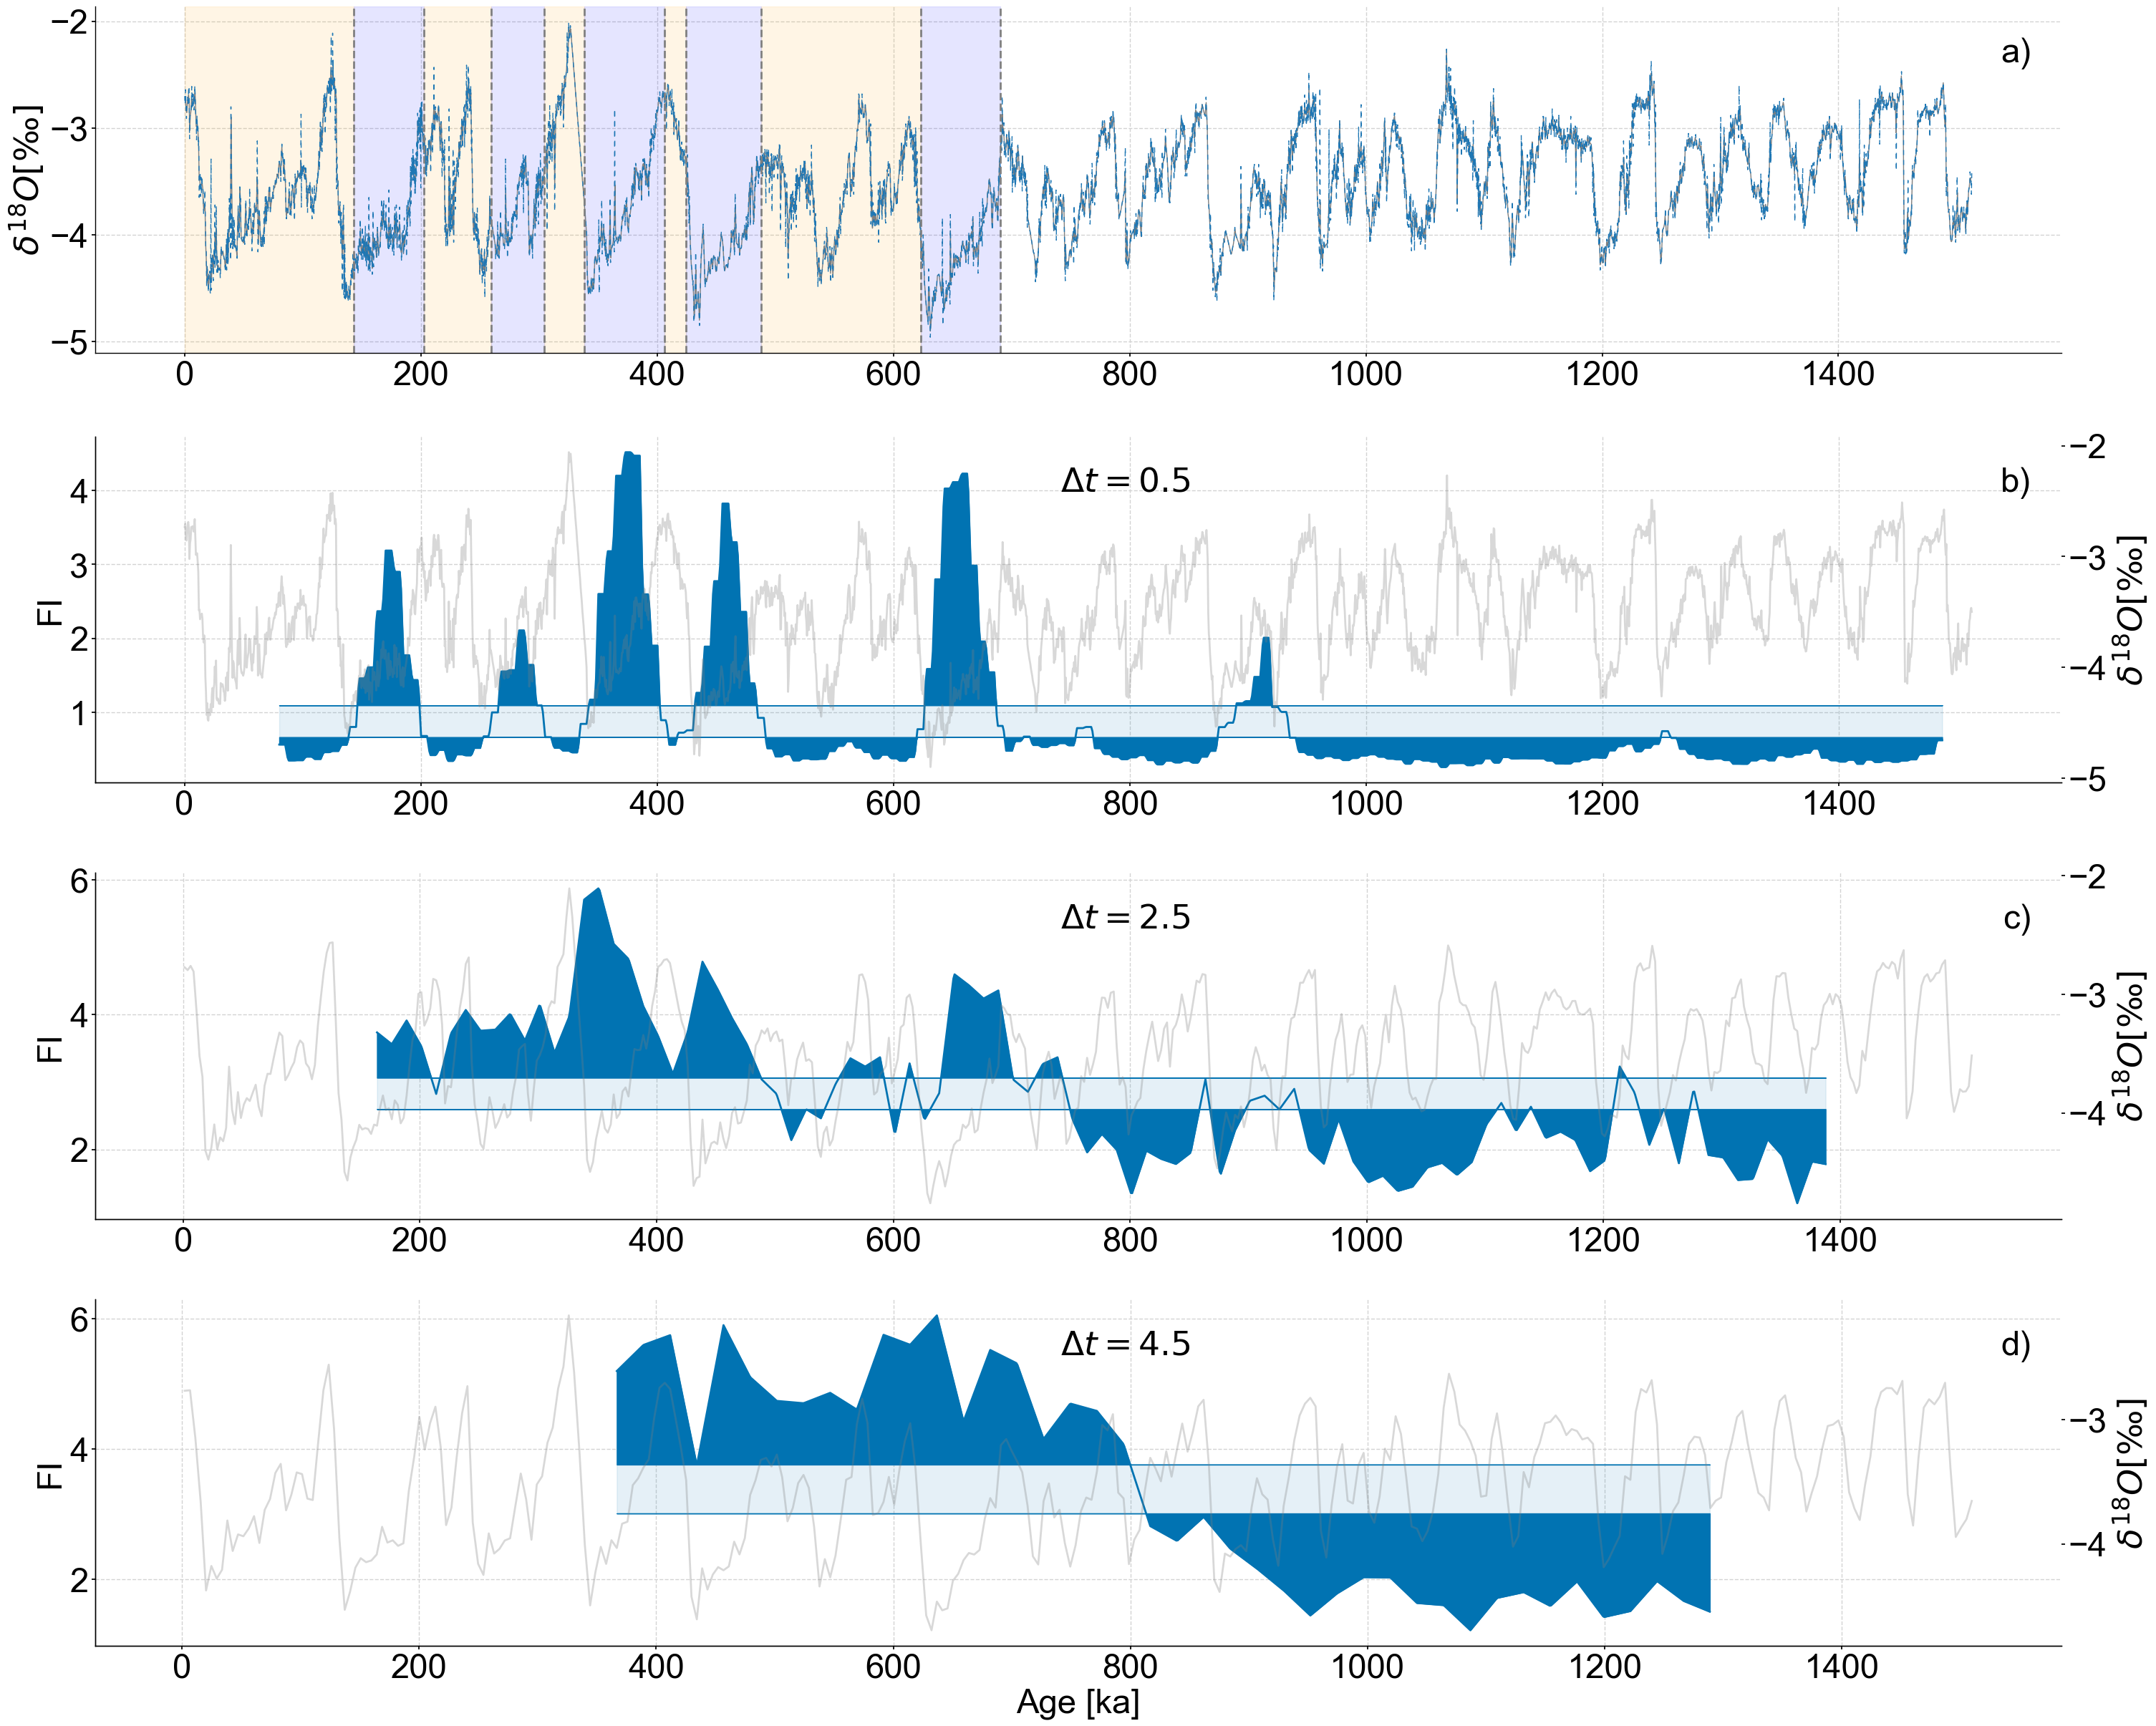

In [5]:
#Production figure

color_list = sns.color_palette('colorblind',4)

SMALL_SIZE = 34
MEDIUM_SIZE = 34
BIGGER_SIZE = 34

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=(30,24),constrained_layout=True)
gs = GridSpec(4, 1, figure=fig,hspace=0.1,wspace=0.01)

ax1 = fig.add_subplot(gs[0,0])
series_lp[bin_sizes[0]].plot(ax=ax1,legend=False,color='grey',linewidth=1)
ts_smooth = ammo.utils.fisher.smooth_series(series=lp_fi[bin_sizes[0]],block_size=3)
upper, lower = ammo.utils.sampling.confidence_interval(series=lp_fi[bin_sizes[0]],upper=95,lower=5,w=50,n_samples=10000)
transitions=detect_transitions(ts_smooth,transition_interval=(upper,lower))

tsb.plot(ax=ax1,linestyle=(0, (5, 5)),linewidth=1,legend=False,alpha=1)
ax1.set_xlabel('')
ax1.set_ylabel(r'$\delta^{18}O [‰]$')

patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='a)')
ax1.legend(handles=[patch],loc='upper right')

flag = 0
for idx,transition in enumerate(transitions):
    if transition <= 800:
        ax1.axvline(transition,color='grey',linestyle='dashed')
        if flag == 0:
            ax1.axvspan(0,transition,color='orange',alpha=.1)
            flag+=1
        elif flag % 2 != 0:
            ax1.axvspan(transitions[idx-1],transition,color='blue',alpha=.1)
            flag+=1
        elif flag % 2 == 0:
            ax1.axvspan(transitions[idx-1],transition,color='orange',alpha=.1)
            flag+=1

ax2 = fig.add_subplot(gs[1,0])
lp_fi[bin_sizes[0]].confidence_fill_plot(ax=ax2,title=None,legend=False)
ax2.set_ylabel('FI')
ax2.set_xlabel('')
ax2_twin = ax2.twinx()
series_lp[bin_sizes[0]].plot(ax=ax2_twin,color='grey',alpha=.3,legend=False)
ax2_twin.set_ylabel(r'$\delta^{18}O [‰]$')
ax2_twin.grid(False)
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='b)')
patch2 = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label=rf'$\Delta t = {bin_sizes[0]}$')
ax2.legend(handles=[patch],loc='upper right')
ax2_twin.legend(handles=[patch2],loc='upper center',prop={'weight':'bold'})

ax3 = fig.add_subplot(gs[2,0])
lp_fi[bin_sizes[1]].confidence_fill_plot(ax=ax3,title=None,legend=False)
ax3.set_ylabel('FI')
ax3.set_xlabel('')
ax3_twin = ax3.twinx()
series_lp[bin_sizes[1]].plot(ax=ax3_twin,color='grey',alpha=.3,legend=False)
ax3_twin.set_ylabel(r'$\delta^{18}O [‰]$')
ax3_twin.grid(False)
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='c)')
patch2 = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label=rf'$\Delta t = {bin_sizes[1]}$')
ax3.legend(handles=[patch],loc='upper right')
ax3_twin.legend(handles=[patch2],loc='upper center',prop={'weight':'bold'})

ax4 = fig.add_subplot(gs[3,0])
lp_fi[bin_sizes[2]].confidence_fill_plot(ax=ax4,title=None,legend=False)
ax4.set_ylabel('FI')
ax4_twin = ax4.twinx()
series_lp[bin_sizes[2]].plot(ax=ax4_twin,color='grey',alpha=.3,legend=False)
ax4_twin.set_ylabel(r'$\delta^{18}O [‰]$')
ax4_twin.grid(False)
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='d)')
patch2 = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label=rf'$\Delta t = {bin_sizes[2]}$')
ax4.legend(handles=[patch],loc='upper right')
ax4_twin.legend(handles=[patch2],loc='upper center',prop={'weight':'bold'})